# Setup

In [1]:
%matplotlib inline

import torch
import random
import copy
import requests #for sending updates to my phone via telegram
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import Counter
from torch.autograd import Variable
from torchvision import datasets, transforms
from operator import itemgetter
from tqdm import tqdm, tnrange, tqdm_notebook



In [2]:
with open(r"D:\TELEGRAM_BOTS\NEURALUPDATES.txt") as file: #Credentials for telegram bot
    BOT_TOKEN, CHANNEL = file.read().split('\n')

## Bokeh and interactive plots

In [50]:
from ipywidgets  import interactive
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, WheelZoomTool
from bokeh.layouts import gridplot

output_notebook()
sns.set()

Loading BokehJS ...

# Dataloaders

## Clean MNIST loaders

In [3]:
torch.manual_seed(1);

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),#normalise to range -1 to 1
                       #transforms.Normalize((0.1307,), (0.3081,)) #normalise pixels using mean and stdev
                       #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])



MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=1000, 
                                          shuffle=True, 
                                          pin_memory=True)

## Adversarial loader

In [ ]:
class AdversarialDataset(torch.utils.data.Dataset):
    """FGSM adversarials of MNIST test set"""

    def __init__(self, root_dir, transform=None):

        self.adversarials = np.load(root_dir+'/adversarials.npy')
        self.labels = np.load(root_dir+'/labels.npy')
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        image = self.adversarials[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return image, label

In [ ]:
adversarials = AdversarialDataset('D:/Data_sets/Adversarial/MNIST')

In [ ]:
adversarial_loader = torch.utils.data.DataLoader(adversarials, 
                                           batch_size=1000, 
                                           shuffle=True, 
                                           pin_memory=True)

# Hyperparameter space

In [6]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [7]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

# Randomise network

In [8]:
def random_value(space):
    """Returns random value from space."""
    
    val = None
    
    if 'func' in space: #randomise optimiser or activation function
        val = random.sample(space['func'], 1)[0] 
    
    elif isinstance(space['lb'], int): #randomise number of units or layers
        val = random.randint(space['lb'], space['ub'])
    
    else: #randomise percentages, i.e. dropout rates or weight decay
        val = random.random() * (space['ub'] - space['lb']) + space['lb']
    
    return val

In [9]:
def randomize_network(layer_space, net_space): 
    """Returns a randomised neural network"""
    net = {}
    
    for key in net_space.keys():
        net[key] = random_value(net_space[key])
        
    layers = []
    
    for i in range(net['nb_layers']):
        layer = {}
        for key in layer_space.keys():
            layer[key] = random_value(layer_space[key])
        layers.append(layer)
        net['layers'] = layers
        
    return net

In [ ]:
randomize_network(LAYER_SPACE, NET_SPACE)

# Mutate network

In [10]:
def mutate_net(nnet, layer_space, net_space):
    
    net = copy.deepcopy(nnet)
    
    
    # mutate optimizer
    for k in ['lr', 'weight_decay', 'optimizer']:
        if random.random() < net_space[k]['mutate']:
            net[k] = random_value(net_space[k])
    
    
    # mutate layers
    for layer in net['layers']:
        for k in layer_space.keys():
            if random.random() < layer_space[k]['mutate']:
                layer[k] = random_value(layer_space[k])
                
                
    # mutate number of layers -- 50% add 50% remove
    if random.random() < net_space['nb_layers']['mutate']:
        if net['nb_layers'] <= net_space['nb_layers']['ub']:
            if random.random()< 0.5 and \
            net['nb_layers'] < net_space['nb_layers']['ub']:
                layer = {}
                for key in layer_space.keys():
                    layer[key] = random_value(layer_space[key])
                net['layers'].append(layer)      
            else:
                if net['nb_layers'] > 1:
                    net['layers'].pop()

                
            # value & id update
            net['nb_layers'] = len(net['layers'])         
            
    return net

# NetBuilder

In [11]:
class Flatten(nn.Module):
    """Flattens input to vector size (batchsize, 1)
    (for use in NetFromBuildInfo)."""

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [12]:
class NetFromBuildInfo(nn.Module):
    def __init__(self, build_info):
        super(NetFromBuildInfo, self).__init__()
        
        self.activation_dict = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'elu': nn.ELU()
            }

        #NETWORK DEFINITION
        
        previous_units = 28 * 28 #MNIST shape
        
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
         
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            
            self.model.add_module(
                'fc_' + i,
                nn.Linear(previous_units, layer_info['nb_units'])
                )
            
            previous_units = layer_info['nb_units']
            
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate'])
                )
            if layer_info['activation'] == 'linear':
                continue #linear activation is identity function
            self.model.add_module(
                layer_info['activation']+ i,
                self.activation_dict[layer_info['activation']])

        self.model.add_module(
            'logits',
            nn.Linear(previous_units, 10) #10 MNIST classes
            )
        
        
        ##OPTIMIZER

        self.opt_args = {#'params': self.model.parameters(),
                 'weight_decay': build_info['weight_decay'],
                 'lr': build_info['lr']
                 }
        
        self.optimizer_dict = {
            'adam': optim.Adam(self.model.parameters(),**self.opt_args),
            'rmsprop': optim.RMSprop(self.model.parameters(),**self.opt_args),
            'adadelta':optim.Adadelta(self.model.parameters(),**self.opt_args),
            'sgd': optim.SGD(self.model.parameters(), **self.opt_args, momentum=0.9) #momentum to train faster
            }

        self.optimizer = self.optimizer_dict[build_info['optimizer']]
        
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Train test helpers

In [13]:
def train(model, train_loader, optimizer, epoch):
    
    model.train(True)
    
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data.cuda()), Variable(target.cuda())
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()

    running_loss /= len(train_loader.dataset)    
    
    if epoch % 100 == 0:
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, running_loss ))

In [14]:
def test(model, test_loader, adversarial=False, eps=0.5):
    
    model.train(False)
    
    test_loss = 0
    correct = 0
    
    if adversarial:
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            data= fgsm(model, data, target, eps=eps)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred).cuda()).sum().item()
            test_loss += F.nll_loss(output, target, size_average=False).item()
        
    else:
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    
    return (test_loss, correct)

# FGSM attack

In [15]:
grads = {} #closure for use as a hook in fgsm attack - otherwise gradients can't be obtained for images. 
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [16]:
def fgsm(model, x, y, eps=0.3, x_val_min=0, x_val_max=1, batch=True): #https://arxiv.org/pdf/1412.6572.pdf
    
    x_adv = Variable(x.data, requires_grad=True).cuda() #clean image
    x_adv.register_hook(save_grad('x_adv'))

    h_adv = model(x_adv) #clean pred
    
    cost = F.nll_loss(h_adv, y.cuda()) #negative log loss clean image and clean pred

    if x_adv.grad is not None:
        x_adv.grad.data.fill_(0)

    cost.backward()

    #x_adv.grad.sign_() #take sign of gradients 
    x_adv = x_adv + (eps*grads['x_adv'].sign())
    x_adv = torch.clamp(x_adv, x_val_min, x_val_max)
    
    if batch == False:
        with torch.no_grad():
            h = model(x)
            h_adv = model(x_adv)

        return x_adv, h_adv, h
    
    return x_adv

# Evolution optimiser

In [19]:
class TournamentOptimizer:
    """Define a tournament play selection process."""

    def __init__(self, population_sz, layer_space, net_space, init_fn, mutate_fn, builder_fn,
                 train_fn, test_fn, data_loader, test_loader):
        
        self.init_fn = init_fn
        self.layer_space = layer_space
        self.net_space = net_space
        self.mutate_fn = mutate_fn
        self.builder_fn = builder_fn
        self.train = train_fn
        self.test = test_fn
        self.dataloader = data_loader
        self.testloader = test_loader
        self.population_sz = population_sz
        
        torch.manual_seed(1);
        
        self.genomes = [init_fn(self.layer_space, self.net_space) for i in range(population_sz)]   
        self.population = []
        
        self.test_results = {} 
        self.genome_history = {} 

        self.generation = 0

    def step(self, generations=1, save=True, phone=False):
        """Tournament evolution step."""

        for _ in tnrange(generations, desc='Overall progress'): #tqdm progress bar

            self.generation += 1

            self.genome_history[self.generation] = self.genomes
            self.population = [NetFromBuildInfo(i).cuda() for i in self.genomes]
            self.children = []
            

            self.train_nets(save=save)
            self.evaluate_nets()

            mean = np.mean(self.test_results[self.generation]['correct'])
            best = np.max(self.test_results[self.generation]['correct'])

            tqdm.write('Generation {} Population mean:{} max:{}'
                       .format(self.generation, mean, best))
            
            if phone: #update via telegram
                requests.post("https://api.telegram.org/bot{}/"
                  "sendMessage".format(BOT_TOKEN), 
                  data={'chat_id': '{}'.format(CHANNEL),
                    'text':'Generation {} completed \n'
                        'Population mean: {} max: {}'
                        .format(self.generation, mean, best)})

                
                

            n_elite = 2
            sorted_pop = np.argsort(self.test_results[self.generation]['correct'])[::-1]
            elite = sorted_pop[:n_elite]
            
            # elites always included in the next population
            self.elite = []
            print('\nTop performers:')
            for no, i in enumerate(elite):
                self.elite.append((self.test_results[self.generation]['correct'][i], 
                                   self.population[i]))    

                self.children.append(self.genomes[i])

                tqdm.write("{}: score:{}".format(no,
                            self.test_results[self.generation]['correct'][i]))   




            #https://stackoverflow.com/questions/31933784/tournament-selection-in-genetic-algorithm
            p = 0.85 # winner probability 
            tournament_size = 3
            probs = [p*((1-p)**i) for i in range(tournament_size-1)]
            probs.append(1-np.sum(probs))
            #probs = [0.85, 0.1275, 0.0224]

            while len(self.children) < self.population_sz:
                pop = range(len(self.population))
                sel_k = random.sample(pop, k=tournament_size)
                fitness_k = list(np.array(self.test_results[self.generation]['correct'])[sel_k])
                selected = zip(sel_k, fitness_k)
                rank = sorted(selected, key=itemgetter(1), reverse=True)
                pick = np.random.choice(tournament_size, size=1, p=probs)[0]
                best = rank[pick][0]
                genome = self.mutate_fn(self.genomes[best], self.layer_space, self.net_space)
                self.children.append(genome)
                
            self.genomes = self.children
                

        
        
    def train_nets(self, save=True):
        """trains population of nets"""
         
        for i, net in enumerate(tqdm_notebook(self.population)):
            for epoch in range(1, 5):
                torch.manual_seed(1);
                self.train(net, self.dataloader, net.optimizer, epoch)
                
            if save:
                fp = r"D:\Models\NeuroEvolution/{}-{}".format(self.generation, i)
                torch.save(net.state_dict(), fp)
                
                
    def evaluate_nets(self):
        """evaluate the models."""
        
        losses = []
        corrects = []
        clean_corrects = []
        
        self.test_results[self.generation] = {}
        
        for i in range(len(self.population)):
            net = self.population[i]
            loss, correct = self.test(net, self.testloader, adversarial=True, eps=0.5) 
            _, clean_correct = self.test(net, self.testloader)
            
            losses.append(loss)
            corrects.append(correct)
            clean_corrects.append(clean_correct)
        
        self.test_results[self.generation]['losses'] = losses
        self.test_results[self.generation]['correct'] = corrects
        self.test_results[self.generation]['clean_correct'] = clean_corrects

# Run 

In [21]:
testing2 = TournamentOptimizer(30, LAYER_SPACE, NET_SPACE, randomize_network, 
                           mutate_net, NetFromBuildInfo, train, test,
                          train_loader, test_loader)

In [22]:
testing2.step(generations=50, save=True, phone=True)

Generation 1 Population mean:2093.4 max:8205

Top performers:
0: score:8205
1: score:8145


Generation 2 Population mean:3028.0666666666666 max:8620

Top performers:
0: score:8620
1: score:8373


Generation 3 Population mean:4808.366666666667 max:9337

Top performers:
0: score:9337
1: score:9233


Generation 4 Population mean:5063.0 max:9457

Top performers:
0: score:9457
1: score:9223


Generation 5 Population mean:4778.633333333333 max:9055

Top performers:
0: score:9055
1: score:8940


Generation 6 Population mean:6833.666666666667 max:9515

Top performers:
0: score:9515
1: score:9515


Generation 7 Population mean:6727.533333333334 max:9505

Top performers:
0: score:9505
1: score:9443


Generation 8 Population mean:7302.933333333333 max:9564

Top performers:
0: score:9564
1: score:9554


Generation 9 Population mean:6690.833333333333 max:9574

Top performers:
0: score:9574
1: score:9564


Generation 10 Population mean:6886.7 max:9582

Top performers:
0: score:9582
1: score:9520


Generation 11 Population mean:7026.533333333334 max:9568

Top performers:
0: score:9568
1: score:9568


Generation 12 Population mean:7355.0 max:9591

Top performers:
0: score:9591
1: score:9568


Generation 13 Population mean:7502.7 max:9622

Top performers:
0: score:9622
1: score:9599


Generation 14 Population mean:6364.6 max:9603

Top performers:
0: score:9603
1: score:9600


Generation 15 Population mean:7176.333333333333 max:9620

Top performers:
0: score:9620
1: score:9607


Generation 16 Population mean:6704.766666666666 max:9643

Top performers:
0: score:9643
1: score:9607


Generation 17 Population mean:6690.133333333333 max:9641

Top performers:
0: score:9641
1: score:9640


Generation 18 Population mean:7499.466666666666 max:9709

Top performers:
0: score:9709
1: score:9641


Generation 19 Population mean:6217.666666666667 max:9672

Top performers:
0: score:9672
1: score:9649


Generation 20 Population mean:7810.0 max:9675

Top performers:
0: score:9675
1: score:9664


Generation 21 Population mean:6121.066666666667 max:9716

Top performers:
0: score:9716
1: score:9666


Generation 22 Population mean:7137.9 max:9707

Top performers:
0: score:9707
1: score:9639


Generation 23 Population mean:7829.0 max:9659

Top performers:
0: score:9659
1: score:9641


Generation 24 Population mean:7770.366666666667 max:9671

Top performers:
0: score:9671
1: score:9652


Generation 25 Population mean:6941.766666666666 max:9683

Top performers:
0: score:9683
1: score:9649


Generation 26 Population mean:7067.466666666666 max:9702

Top performers:
0: score:9702
1: score:9665


Generation 27 Population mean:7084.466666666666 max:9691

Top performers:
0: score:9691
1: score:9683


Generation 28 Population mean:6653.333333333333 max:9691

Top performers:
0: score:9691
1: score:9659


Generation 29 Population mean:6586.033333333334 max:9716

Top performers:
0: score:9716
1: score:9691


Generation 30 Population mean:6565.866666666667 max:9686

Top performers:
0: score:9686
1: score:9648


Generation 31 Population mean:6003.4 max:9627

Top performers:
0: score:9627
1: score:9609


Generation 32 Population mean:5970.9 max:9704

Top performers:
0: score:9704
1: score:9675


Generation 33 Population mean:6923.433333333333 max:9672

Top performers:
0: score:9672
1: score:9670


Generation 34 Population mean:8360.833333333334 max:9724

Top performers:
0: score:9724
1: score:9696


Generation 35 Population mean:7551.566666666667 max:9692

Top performers:
0: score:9692
1: score:9681


Generation 36 Population mean:6407.133333333333 max:9677

Top performers:
0: score:9677
1: score:9660


Generation 37 Population mean:7493.766666666666 max:9679

Top performers:
0: score:9679
1: score:9677


Generation 38 Population mean:5766.466666666666 max:9644

Top performers:
0: score:9644
1: score:9638


Generation 39 Population mean:6752.066666666667 max:9702

Top performers:
0: score:9702
1: score:9696


Generation 40 Population mean:7115.766666666666 max:9660

Top performers:
0: score:9660
1: score:9630


Generation 41 Population mean:8187.533333333334 max:9688

Top performers:
0: score:9688
1: score:9687


Generation 42 Population mean:6535.033333333334 max:9688

Top performers:
0: score:9688
1: score:9684


Generation 43 Population mean:7384.733333333334 max:9688

Top performers:
0: score:9688
1: score:9684


Generation 44 Population mean:7384.666666666667 max:9699

Top performers:
0: score:9699
1: score:9688


Generation 45 Population mean:6557.633333333333 max:9692

Top performers:
0: score:9692
1: score:9685


Generation 46 Population mean:7432.2 max:9710

Top performers:
0: score:9710
1: score:9663


Generation 47 Population mean:6203.8 max:9688

Top performers:
0: score:9688
1: score:9686


Generation 48 Population mean:6495.6 max:9688

Top performers:
0: score:9688
1: score:9667


Generation 49 Population mean:7398.133333333333 max:9713

Top performers:
0: score:9713
1: score:9688


Generation 50 Population mean:5912.066666666667 max:9714

Top performers:
0: score:9714
1: score:9688



# Progress plots

## Plot func definitions 

In [23]:
def progressplotter(optimizer, clean=False):
    
    if clean:
        dataset = 'clean_correct'
    else:
        dataset = 'correct'
    
    means = []
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    gens = range(len(optimizer.test_results))
    popsize = len(optimizer.test_results[1][dataset])
    
    for i in gens:
        ax.scatter([i for j in range(popsize)], optimizer.test_results[i+1][dataset])
        mean = np.mean(optimizer.test_results[i+1][dataset])
        means.append(mean)
        ax.scatter(i, mean, c=1)
        
        if i == 0:
            continue
        plt.plot([i-1, i], [means[i-1], mean], c='black')
        
    ax.set_xticks(np.arange(0, len(means),1))
    ax.set_xlabel('Generation')
    ax.set_ylabel('Correct classifications')
    
    if clean:
        ax.set_title('Accuracy on clean dataset')
    else:
        ax.set_title('Accuracy on adversarial dataset')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

In [24]:
def diffplotter(optimizer):
    diff = {}
    for gen in optimizer.test_results:
        diff[gen] = []
        for i in range(len(optimizer.test_results[gen]['clean_correct'])):
            clean = optimizer.test_results[gen]['clean_correct'][i]
            adver = optimizer.test_results[gen]['correct'][i]
            diff[gen].append(clean - adver)
            
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    gens = len(optimizer.test_results)
    popsize = len(optimizer.test_results[gen]['clean_correct'])

    for i in range(gens):
        ax.scatter([i for j in range(popsize)], diff[i+1])
        
    ax.set_title('Difference between clean and adversarial accuracy')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Clean accuracy - adversarial accuracy')
    
    ax.set_xticks(np.arange(0, gens,1))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

In [25]:
def bestplotter(optimizer, k=0):

    holder = {
        'clean accuracy' : [],
        'adversarial accuracy' : [],
        'number of layers' : [],
        'activation function' : [],
        'dropout rate' : [],
        'optimizer' : [],
        'number of units in layer' : [],
        'learning rate' : [],
    }

    for gen in optimizer.test_results:

        curr = optimizer.test_results[gen]

        best_index = np.argsort(curr['correct'])[::-1][k]

        holder['clean accuracy'].append(curr['clean_correct'][best_index])
        holder['adversarial accuracy'].append(curr['correct'][best_index])

        genome = optimizer.genome_history[gen][best_index]

        holder['number of layers'].append(genome['nb_layers'])
        holder['dropout rate'].append(genome['layers'][0]['dropout_rate'])
        holder['number of units in layer'].append(genome['layers'][0]['nb_units'])
        holder['optimizer'].append(genome['optimizer'])
        holder['activation function'].append(genome['layers'][0]['activation'])
        holder['learning rate'].append(genome['lr'])
        
    gens = len(holder['clean accuracy'])
    
    fig = plt.figure(figsize=(20,20))
    
    for i in range(8):
        ax = fig.add_subplot(4,2, i+1)
        ax.set_ylabel(list(holder.keys())[i])
        ax.set_xlabel('Generation')
        ax.set_xticks(np.arange(0, gens,5))
        ax.yaxis.label.set_fontsize(15)
        
        
        
        for j in range(gens):
            ax.scatter(j, holder[list(holder.keys())[i]][j], c='black')

In [26]:
def avgplotter(optimizer):

    holder = {
        'clean accuracy' : [],
        'adversarial accuracy' : [],
        'number of layers' : [],
        'activation function' : [],
        'dropout rate' : [],
        'optimizer' : [],
        'number of units in layer' : [],
        'learning rate' : [],
    }

    for gen in optimizer.test_results:

        curr = optimizer.test_results[gen]
        genomes = optimizer.genome_history[gen]
        
        templist1 = []
        templist2 = []
        templist3 = []
        templist4 = []
        templist5 = []
        templist6 = []
        for net in genomes:
            templist1.append(net['nb_layers'])
            templist2.append(net['optimizer'])
            templist3.append(net['lr'])
            templist4.append(net['layers'][0]['dropout_rate'])
            templist5.append(net['layers'][0]['nb_units'])
            templist6.append(net['layers'][0]['activation'])
            
            
        holder['number of layers'].append(np.mean(templist1))
        holder['optimizer'].append(Counter(templist2).most_common()[0][0])
        holder['learning rate'].append(np.mean(templist3))
        holder['dropout rate'].append(np.mean(templist4))
        holder['number of units in layer'].append(np.mean(templist5))
        holder['activation function'].append(Counter(templist6).most_common()[0][0])
        

        holder['clean accuracy'].append(np.mean(curr['clean_correct']))
        holder['adversarial accuracy'].append(np.mean(curr['correct']))
            

    gens = len(holder['clean accuracy'])
    
    fig = plt.figure(figsize=(20,20))
    
    for i in range(8):
        ax = fig.add_subplot(4,2, i+1)
        ax.set_ylabel(list(holder.keys())[i])
        ax.set_xlabel('Generation')
        ax.set_xticks(np.arange(0, gens,5))
        ax.yaxis.label.set_fontsize(15)
        
        for j in range(gens):
            ax.scatter(j, holder[list(holder.keys())[i]][j], c='black')

## Plots 

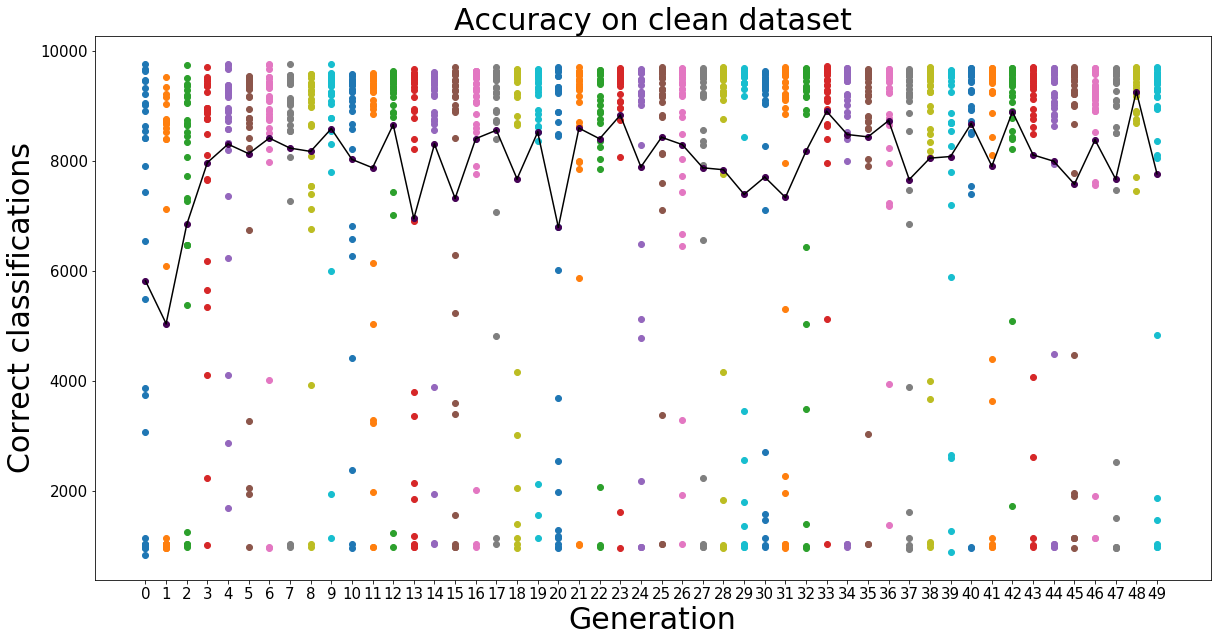

In [27]:
progressplotter(testing2, clean=True)

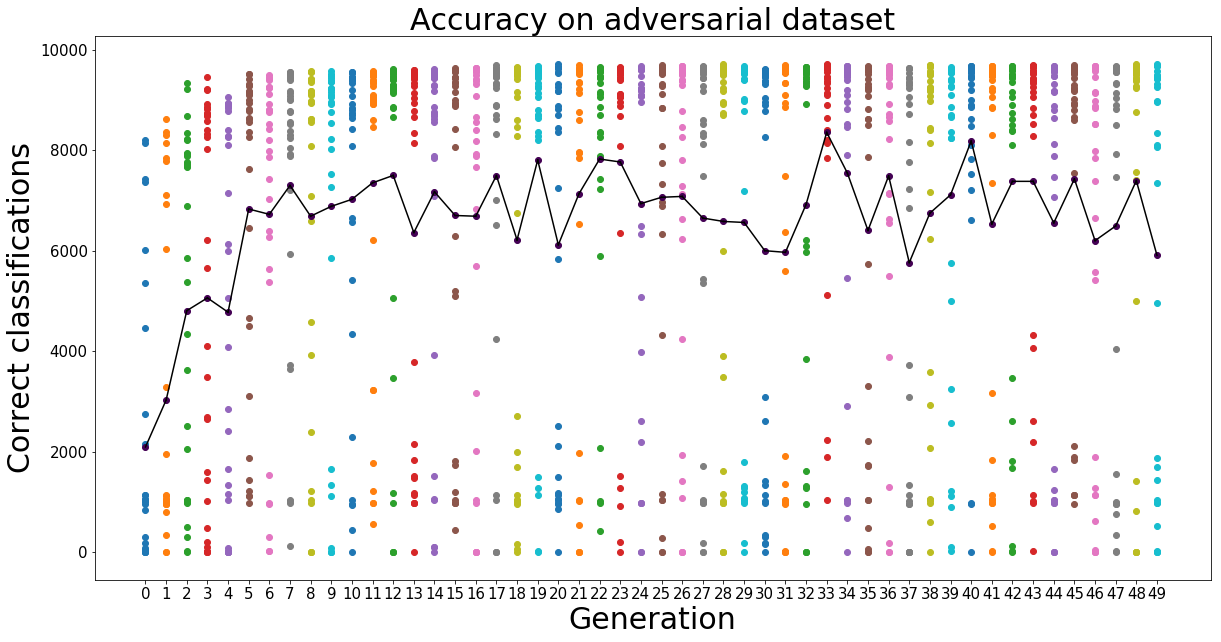

In [28]:
progressplotter(testing2)

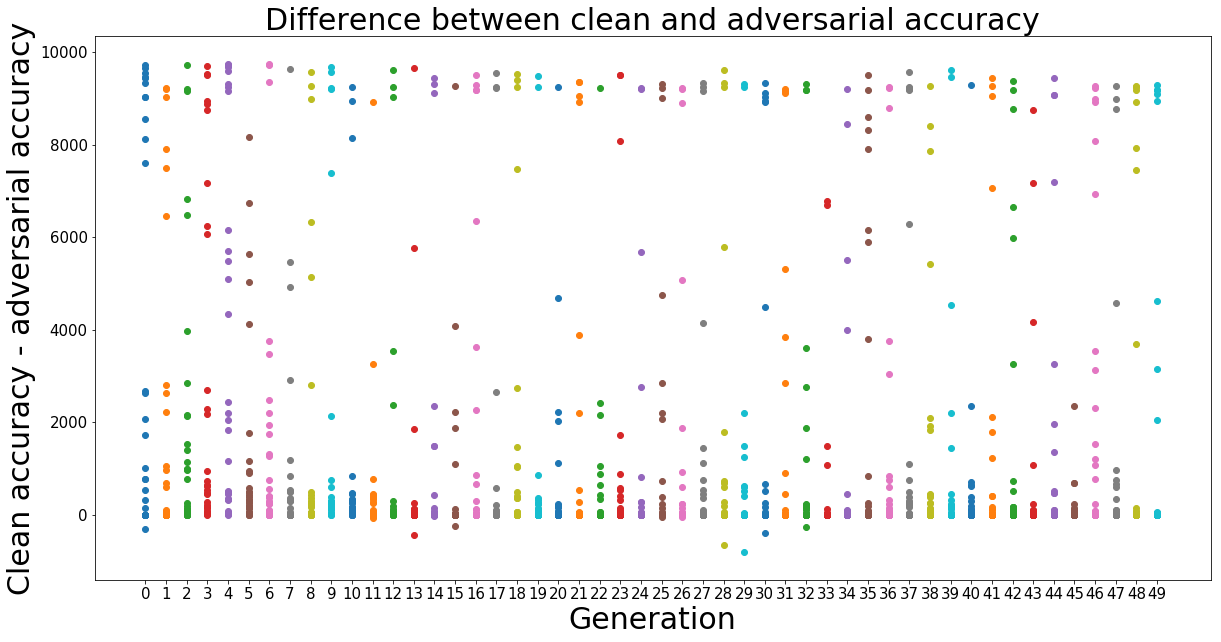

In [29]:
diffplotter(testing2)

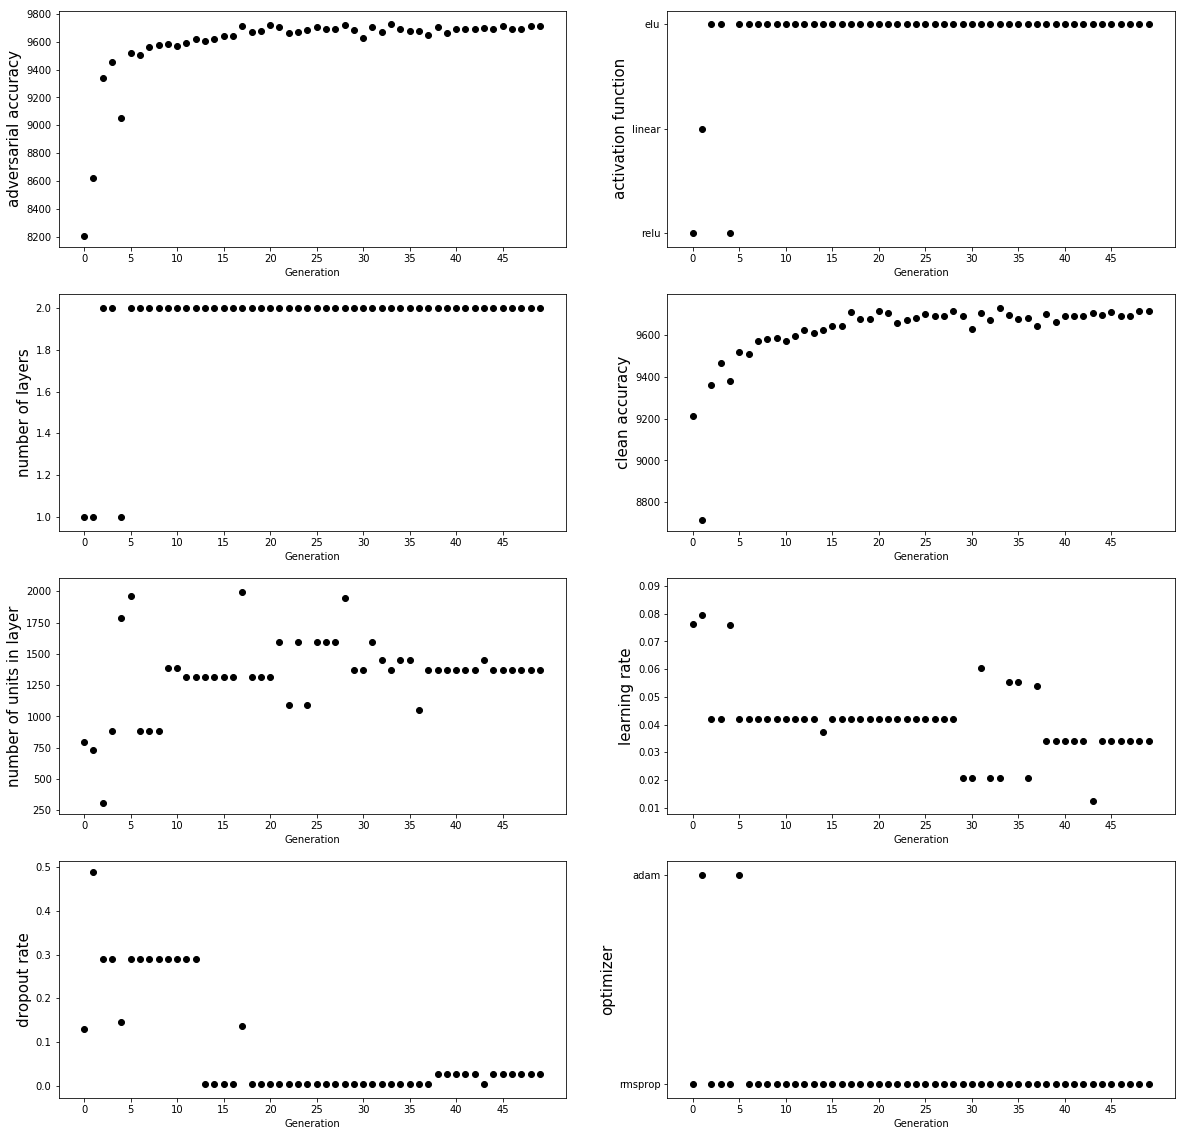

In [30]:
bestplotter(testing2, k=0)

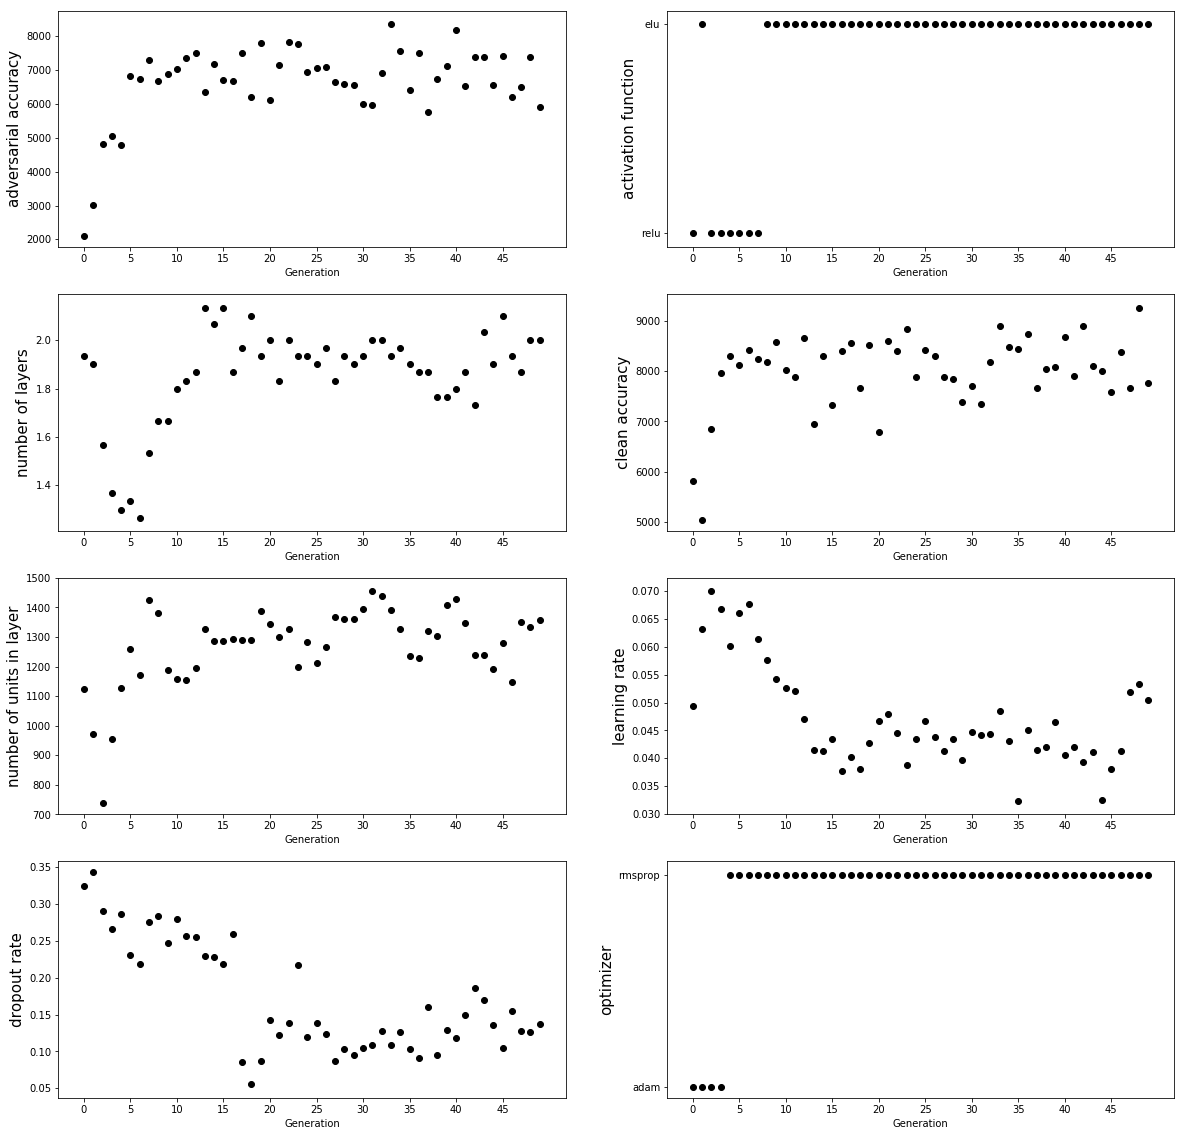

In [31]:
avgplotter(testing2)

# Tests

In [32]:
def rebuild_from_save(optimizer, generation, position):
    
    genome = optimizer.genome_history[generation][position]
    
    net = NetFromBuildInfo(genome)
    
    net.load_state_dict(torch.load(r"D:\Models\NeuroEvolution\{}-{}".format(generation, position)))
    
    return net.cuda()

In [33]:
def sanity_check(optimizer, test_loader):
    
    for generation in optimizer.test_results:
        print('generation {}: \n'.format(generation))
        for i, result in enumerate(optimizer.test_results[generation]['correct']):
            
            mod = rebuild_from_save(optimizer, generation, i)
            _, rebuild_result = test(mod, test_loader, adversarial=True, eps=0.5)
            
            if result == rebuild_result:
                print("result = {}, rebuild result = {}. (equal)".format(result, rebuild_result))
            else:
                print("result = {}, rebuild result = {}. (different!!)".format(result, rebuild_result))

In [34]:
sanity_check(testing2, test_loader)

generation 1: 

result = 1009, rebuild result = 1009. (equal)
result = 1067, rebuild result = 1067. (equal)
result = 8145, rebuild result = 8145. (equal)
result = 6010, rebuild result = 6010. (equal)
result = 1032, rebuild result = 1032. (equal)
result = 182, rebuild result = 182. (equal)


KeyboardInterrupt: 

# Best model plots 

## Definitions

In [35]:
def get_best_model(optimizer, adversarial=True):
    current_best = 0
    for i, gen in enumerate(optimizer.test_results):
        if adversarial: 
            generation_correct = optimizer.test_results[gen]['correct']
        else:
            generation_correct = optimizer.test_results[gen]['clean_correct']
        for j, score in enumerate(generation_correct):
            if score > current_best:
                best_gen = gen
                best_pos = j
                current_best = score
    clean_score = optimizer.test_results[best_gen]['clean_correct'][best_pos]
    adv_score = optimizer.test_results[best_gen]['correct'][best_pos]
                
    return [best_gen, clean_score, adv_score, rebuild_from_save(optimizer, best_gen, best_pos)]

In [36]:
def best_printer(optimizer):
    holdict = {}
    holdict['best_clean'] = {}
    holdict['best_adversarial'] = {}
    
    holdict['best_clean']['generation'] , \
    holdict['best_clean']['clean'], \
    holdict['best_clean']['adversarial'], _ = get_best_model(testing2, adversarial=False)
    
    holdict['best_adversarial']['generation'] , \
    holdict['best_adversarial']['clean'], \
    holdict['best_adversarial']['adversarial'], _ = get_best_model(testing2, adversarial=True)
    
    return pd.DataFrame(holdict).T

In [37]:
def multi_plot(optimizer, data_loader, adversarial=False, eps=0.5):
    
    best_gen, best_clean_score, best_adv_score, best_model = get_best_model(optimizer)
    batch = next(iter(data_loader))
    
    print("Showing best model which was found in generation {}\n"
          "Clean accuracy = {}\nadversarial accuracy ={}\n\n"
         "Model: \n\n".format(best_gen, best_clean_score,
                           best_adv_score), best_model, "\n\n",
          "Images below are {}"
          .format('adversarial' if adversarial else 'clean'))

    fig = plt.figure(figsize=(20,20))

    counter=0
    for i in range(len(batch[1])):
        if batch[1][i].item() == counter:
            #do stuff
            counter+=1
            if counter == 10: break
            ax = fig.add_subplot(3,3, counter)
            if adversarial:
                image, _, _ = fgsm(best_model, batch[0][i].view(1,1,28,28).cuda(),
                                   batch[1][i].view(1), eps=eps, batch=False)      
            else:
                image = batch[0][i]
            softmax = F.softmax(best_model(image.view(1,1,28,28).cuda()), dim=1)
            prediction = softmax.argmax()
            prediction_pct = softmax.max()
            ax.imshow(image.detach().cpu().numpy().reshape(28,28))
            ax.text(x=3, y=31, s="Predicted: {x} ({y:.2f})"
                     .format(x=prediction, y=prediction_pct), fontsize=20)

## Plots

In [38]:
best_printer(testing2)

,adversarial,clean,generation
best_adversarial,9724,9729,34
best_clean,42,9771,1


Showing best model which was found in generation 34
Clean accuracy = 9729
adversarial accuracy =9724

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1370, bias=True)
    (dropout_0): Dropout(p=0.003776959867906404)
    (elu0): ELU(alpha=1.0)
    (fc_1): Linear(in_features=1370, out_features=1220, bias=True)
    (dropout_1): Dropout(p=0.5211939080330473)
    (logits): Linear(in_features=1220, out_features=10, bias=True)
  )
) 

 Images below are adversarial


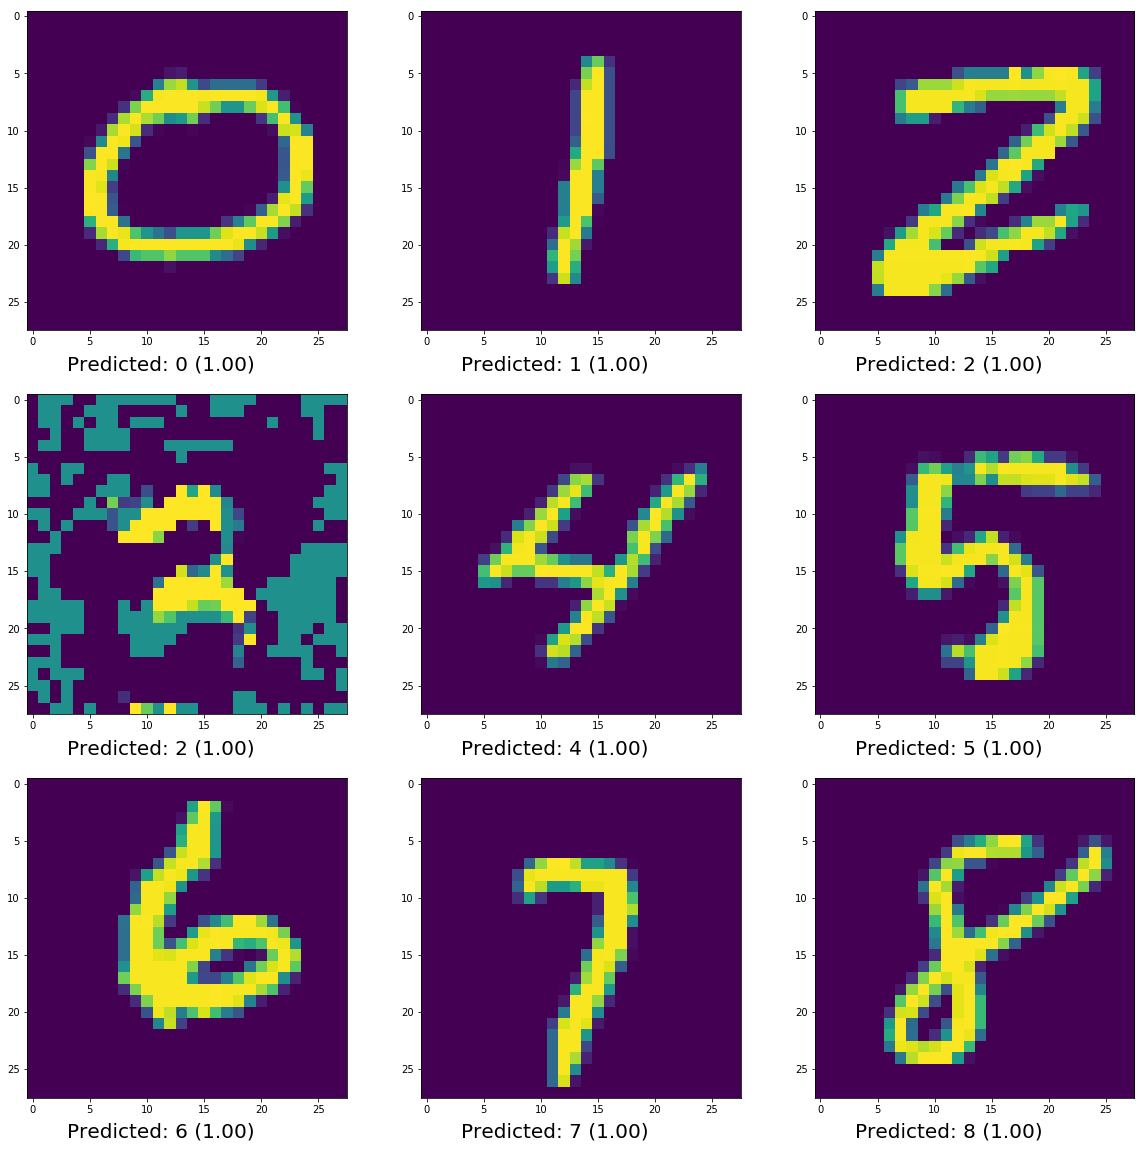

In [39]:
multi_plot(testing2, test_loader, adversarial=True, eps=0.5)

Showing best model which was found in generation 34
Clean accuracy = 9729
adversarial accuracy =9724

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1370, bias=True)
    (dropout_0): Dropout(p=0.003776959867906404)
    (elu0): ELU(alpha=1.0)
    (fc_1): Linear(in_features=1370, out_features=1220, bias=True)
    (dropout_1): Dropout(p=0.5211939080330473)
    (logits): Linear(in_features=1220, out_features=10, bias=True)
  )
) 

 Images below are clean


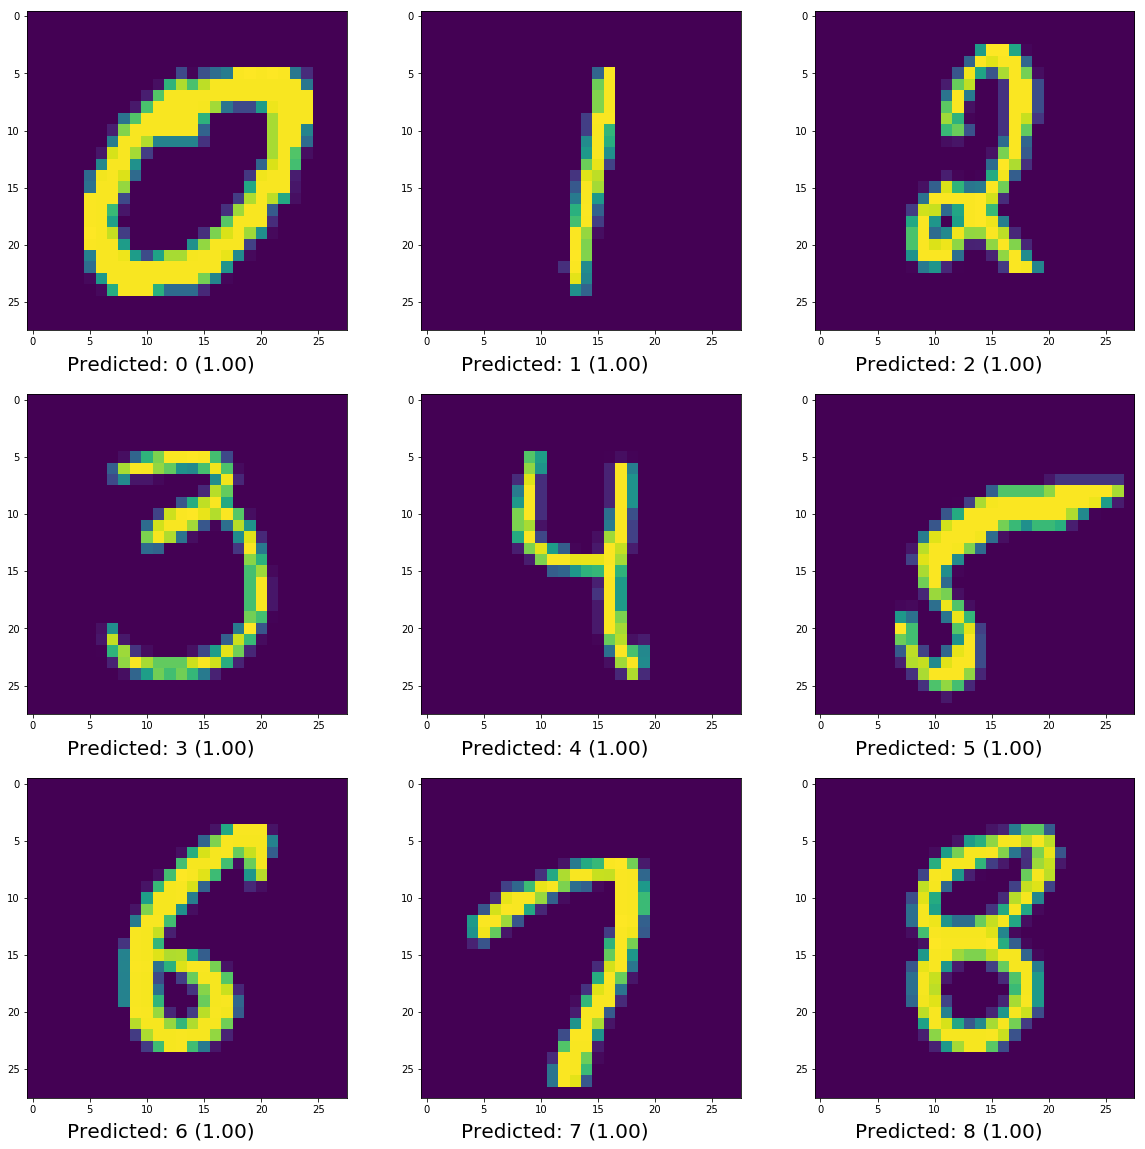

In [40]:
multi_plot(testing2, test_loader, adversarial=False)

# Comparison plots

## Definitions 

In [41]:
_,_,_, best_model = get_best_model(testing2)

In [42]:
eps_dict = {}

for i in tqdm_notebook(range(101)):
    eps_dict[i/100] = test(best_model, test_loader, adversarial = True, eps=i/100)[1]

In [43]:
df =pd.DataFrame(eps_dict, index=['Accuracy']).T
df.index.name = 'epsilon'
df = df.reset_index()

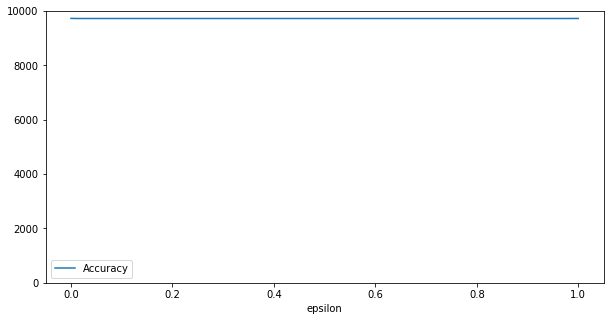

In [44]:
df.plot('epsilon', figsize=(10,5), ylim=[0,10000])

## bokeh progress 

In [45]:
def dataframer(optimizer):
    
    number_of_layers = []
    learning_rate = []
    act_func = []
    number_of_units_1 = []
    dropout_rate = []
    genome_hist = []
    generations = []
    clean_scores = []
    adv_scores = []
    
    for generation in optimizer.test_results:

        scores = optimizer.test_results[generation]
        genomes = optimizer.genome_history[generation]

        clean_scores += scores['clean_correct']
        adv_scores += scores['correct']

        for genome in genomes:
            
            generations.append(generation)
            genome_hist.append(genome)
            number_of_layers.append(genome['nb_layers'])
            learning_rate.append(genome['lr'])

            act_func.append(genome['layers'][0]['activation'])
            number_of_units_1.append(genome['layers'][0]['nb_units'])
            dropout_rate.append(genome['layers'][0]['dropout_rate'])

            df = pd.DataFrame([generations, clean_scores, adv_scores, number_of_layers,
                             learning_rate, act_func, 
                             number_of_units_1, dropout_rate, genome_hist]).T

            df.columns = ['Generation', 'Clean','Adversarial','No_layers',
                          'Lr', 'Act_func', 'Nb_units', 'Dropout', 'Genome']
    
    return df

In [46]:
df = dataframer(testing2)

In [47]:
df.to_pickle(r"../data/neuroevolution3")

In [ ]:
df = pd.read_pickle(r"../data/neuroevolution1")

In [ ]:
df

In [53]:
def f(x, y, x2, y2, gen):
    if gen == 'all':
        source = ColumnDataSource(df.iloc[:, :-1])#last column contains dicts which causes bokeh to fail
    else: 
        source = ColumnDataSource(df[df['Generation']==gen].iloc[:, :-1]) 
    
    tiplist = [("Accuracy", "@Clean"), 
            ("Adversarial accuracy", "@Adversarial"),
            ("Number of layers", "@No_layers"),
            ("Generation", "@Generation"),
            ("Activation function", "@Act_func"),
              ("Dropout", "@Dropout")]
    
    options = dict(plot_width=400, plot_height=400,
                   tools="pan,wheel_zoom,box_zoom,box_select,lasso_select",
                  active_scroll= 'wheel_zoom')

    p1 = figure(title="{} vs {}".format(y, x), **options)
    p1.scatter(x, y, color="blue", source=source,
               hover_line_color="black")#, radius=0.1)
    p1.xaxis.axis_label = x
    p1.yaxis.axis_label = y
    if y in ['Adversarial', 'Clean']:
        p1.y_range.start = -1000
        p1.y_range.end = 11000
    p1.add_tools(HoverTool(tooltips=tiplist))

    p2 = figure(title="{} vs {}".format(y2, x2), **options)
    p2.scatter(x2, y2, color="green", source=source, 
               hover_line_color="black")#, radius=0.1)
    p2.xaxis.axis_label = x2
    p2.yaxis.axis_label = y2
    if y2 in ['Adversarial', 'Clean']:
        p2.y_range.start = -1000
        p2.y_range.end = 11000
    p2.add_tools(HoverTool(tooltips=tiplist))

    p = gridplot([[ p1, p2]], toolbar_location="left")

    show(p)

In [54]:
opts = df.columns.tolist()[:-1] #last column contains dicts which causes bokeh to fail
gen_opts = ['all'] + df['Generation'].unique().tolist() 
y1_opts = opts[2:] + opts[:2]
y2_opts = opts[1:] + opts[:1]
interactive_plot = interactive(f, x=opts, y=y1_opts, x2=opts, y2=y2_opts, gen=gen_opts)

In [55]:
interactive_plot

interactive(children=(Dropdown(description='x', options=('Generation', 'Clean', 'Adversarial', 'No_layers', 'L…